In [20]:
import csv
import json
import random
import sys
from typing import Dict

import numpy as np
from scipy.stats import linregress

import main
import matplotlib.pyplot as plt

from tva_io import scheme_by_name
from tva_types import Scheme

random.seed(42)

def generate_preferences_csv(num_voters: int, num_candidates: int, filename: str) -> None:
    candidates = [chr(65 + i) for i in range(num_candidates)]  # Candidate labels A, B, C, ...
    preferences = []
    for _ in range(num_voters):
        column = random.sample(candidates, num_candidates)
        preferences.append(column)
    preferences = list(zip(*preferences))  # Transpose the list to have each row represent a voter
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for preference in preferences:
            writer.writerow(preference)

  
            
def read_output(filename: str) -> dict:
    with open(filename, 'r') as file:
        return json.load(file)

def plot_strategic_voting_risk(data):
    risks = [details['strategic_voting_risk'] for scheme, details in data.items() if 'strategic_voting_risk' in details]
    schemes = [scheme for scheme in data if 'strategic_voting_risk' in data[scheme]]

    plt.bar(schemes, risks, color='skyblue')
    plt.xlabel('Voting Scheme')
    plt.ylabel('Strategic Voting Risk')
    plt.title('Strategic Voting Risk by Voting Scheme')
    plt.xticks(rotation=45)
    plt.show()

def get_happiness_by_scheme(output: dict) -> Dict[str, float]:
    return {scheme: details["non_strategic_overall_happiness"] for scheme, details in output.items()}

def get_risk_by_scheme(output: dict) -> Dict[str, float]:
    return {scheme: details["strategic_voting_risk"] for scheme, details in output.items()}

def get_max_happiness_increase_by_scheme(data):
    avg_increases = {}
    for scheme in data.keys():
        total_increase = 0
        voters_count = 0
        for voter_data in data[scheme]['voters'][0]:  # Assuming the first list contains relevant voter data
            increase = voter_data['voter_happiness'] - voter_data['true_voter_happiness']
            total_increase += increase
            voters_count += 1
        avg_increases[scheme] = total_increase / voters_count if voters_count > 0 else 0
    return avg_increases

def get_max_happiness_and_increase_by_scheme(data, scheme_name):
    maximum_happiness = 0
    total_increase = 0
    for scheme in data.keys():
        if(scheme != scheme_name):
            continue
        for voter_data in data[scheme]['voters'][0]:  # Assuming the first list contains relevant voter data
            if voter_data['voter_happiness'] > maximum_happiness:
                maximum_happiness = voter_data['voter_happiness']
                total_increase = voter_data['voter_happiness'] - voter_data['true_voter_happiness']
            
    return maximum_happiness, total_increase

def run_experiment(candidate_numbers, voter_numbers, schemes):
    # Adjusting the structure to accommodate schemes at the top level
    results = {scheme: {num_candidates: {'happiness': [], 'risk': [], 'avg_increase': [], 'avg_max_happiness': []} 
                        for num_candidates in candidate_numbers} for scheme in schemes.keys()}

    for num_voters in voter_numbers:
        print(f"Running experiment for {num_voters} voters")
        for num_candidates in candidate_numbers:
            print(f"Number of candidates: {num_candidates}")
            # Generate preferences
            filename = "exp_preferences.csv"
            generate_preferences_csv(num_voters, num_candidates, filename)
            
            output_filename = "exp_output.json"
            main.main(schemes, [[]], filename, output_filename)  # Assuming main function is adapted to accept schemes this way
            output = read_output(output_filename)
            
            # Run analysis and get output for each scheme
            for scheme, _ in schemes.items():
                # Extract metrics for current scheme
                happiness = output[scheme]["non_strategic_overall_happiness"]/num_voters
                risk = output[scheme]["strategic_voting_risk"]
                max_increase, max_happiness = get_max_happiness_and_increase_by_scheme(output,scheme)

                # Store metrics for current scheme, candidate number, and voter count
                results[scheme][num_candidates]['happiness'].append(happiness)
                results[scheme][num_candidates]['risk'].append(risk)
                results[scheme][num_candidates]['avg_increase'].append(max_increase)
                results[scheme][num_candidates]['avg_max_happiness'].append(max_happiness)

    return results, voter_numbers

def plot_metrics_for_all_schemes(results, voter_numbers, schemes):
    num_schemes = len(schemes)
    num_metrics = 4  # Assuming 4 metrics: happiness, risk, avg_increase, avg_max_happiness
    fig, axs = plt.subplots(num_schemes, num_metrics, figsize=(20, num_schemes * 5), squeeze=False)
    
    # Assuming voter_numbers is a list of integers representing the indexes for the metrics
    # If not, you'll need to adjust how you're using voter_numbers in plotting

    for scheme_idx, scheme in enumerate(schemes.keys()):
        metrics_for_scheme = results.get(scheme, {})
        
        # Initialize a dictionary to hold aggregated metric values
        aggregated_metrics = {metric: [] for metric in ['happiness', 'risk', 'avg_increase', 'avg_max_happiness']}
        
        # Aggregate metric values across all candidate numbers
        for candidate_number, metrics in metrics_for_scheme.items():
            for metric in aggregated_metrics.keys():
                aggregated_metrics[metric].extend(metrics.get(metric, []))
        
        for metric_idx, (metric, color, title) in enumerate([
            ('happiness', 'blue', 'Non-Strategic Overall Happiness'),
            ('risk', 'red', 'Strategic Voting Risk'),
            ('avg_increase', 'green', 'Average Happiness Increase'),
            ('avg_max_happiness', 'purple', 'Average Maximum Happiness')]):
            
            y_values = aggregated_metrics[metric]
            
            if len(y_values) != len(voter_numbers):
                print(f"Length mismatch for {metric} in {scheme}: {len(y_values)} vs {len(voter_numbers)}")
                continue  # Skip plotting this metric due to length mismatch
            
            # Fit and plot trend line for aggregated metrics
            coefficients = np.polyfit(voter_numbers, y_values, deg=2)
            trend_poly = np.poly1d(coefficients)
            trend_line = trend_poly(np.array(voter_numbers))

            ax = axs[scheme_idx, metric_idx]
            ax.plot(voter_numbers, trend_line, color=color, label=f'{title} Trend ({scheme})')
            ax.scatter(voter_numbers, y_values, color=color, alpha=0.5, label='Data Points ({scheme})')
            ax.set_title(f'{title} ({scheme})')
            ax.set_xlabel('Number of Voters')
            ax.set_ylabel(title)
            ax.legend()

    plt.tight_layout()
    plt.show()

def plot_combined_metrics_with_trends(results, voter_numbers):
    num_plots = len(results.keys())
    fig, axs = plt.subplots(num_plots, 4, figsize=(20, num_plots * 5), squeeze=False)  # Ensure axs is always 2D

    candidate_numbers = list(results.keys())
    for idx, num_candidates in enumerate(candidate_numbers):
        metrics = results[num_candidates]

        for ax, metric, color, title in zip(axs[idx, :],
                                            ['happiness', 'risk', 'avg_increase', 'avg_max_happiness'],
                                            ['blue', 'red', 'green', 'purple'],
                                            ['Non-Strategic Overall Happiness', 'Strategic Voting Risk',
                                             'Average Happiness Increase', 'Average Maximum strategic Happiness']):
            y_values = metrics[metric]
            # Linear regression for trend
            slope, intercept, _, _, _ = linregress(voter_numbers, y_values)
            trend_line = np.array(voter_numbers) * slope + intercept

            # Plot the trend line
            ax.plot(voter_numbers, trend_line, color=color, label=f'{title} Trend')
            # Optionally, plot the individual data points
            ax.scatter(voter_numbers, y_values, color=color, alpha=0.5, label='Data Points')

            ax.set_title(f'{title} (Candidates={num_candidates})')
            ax.set_xlabel('Number of Voters')
            ax.set_ylabel(title)
            ax.legend()

    plt.tight_layout()
    plt.show()
    
def plot_combined_metrics_with_nonlinear_trends(results, voter_numbers):
    num_plots = len(results.keys())
    fig, axs = plt.subplots(num_plots, 4, figsize=(20, num_plots * 5), squeeze=False)  # Ensure axs is always 2D

    candidate_numbers = list(results.keys())
    for idx, num_candidates in enumerate(candidate_numbers):
        metrics = results[num_candidates]

        for ax, metric, color, title in zip(axs[idx, :],
                                            ['happiness', 'risk', 'avg_increase'],
                                            ['blue', 'red', 'green'],
                                            ['Non-Strategic Overall Happiness', 'Strategic Voting Risk',
                                             'Average Happiness Increase']):
            y_values = metrics[metric]
            # Polynomial regression for trend
            coefficients = np.polyfit(voter_numbers, y_values, 2)
            polynomial = np.poly1d(coefficients)
            trend_line = polynomial(voter_numbers)

            # Plot the trend line
            ax.plot(voter_numbers, trend_line, color=color, label=f'{title} Trend')
            # Optionally, plot the individual data points
            ax.scatter(voter_numbers, y_values, color=color, alpha=0.5, label='Data Points')

            ax.set_title(f'{title} (Candidates={num_candidates})')
            ax.set_xlabel('Number of Voters')
            ax.set_ylabel(title)
            ax.legend()

    plt.tight_layout()
    plt.show()

In [3]:
scheme_names = ["plurality", "voting_for_two", "borda", "anti_plurality"]
collusion_groups = [[0, 3],[2],[1],[4]]

    # Set voting schemes
schemes: Dict[str, Scheme] = {}
scheme_names = scheme_names
for scheme_name in scheme_names:
    scheme = scheme_by_name(scheme_name)
    if scheme == None:
        print("Invalid voting scheme:", scheme_name)
        sys.exit(1)
    schemes[scheme_name] = scheme
print("Voting schemes:", scheme_names)

Voting schemes: ['plurality', 'voting_for_two', 'borda', 'anti_plurality']


Running experiment for 5 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 8 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 11 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 14 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 17 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 20 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 23 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 26 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 29 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 32 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 35 voters
Number of candidates: 4
Results written to exp_ou

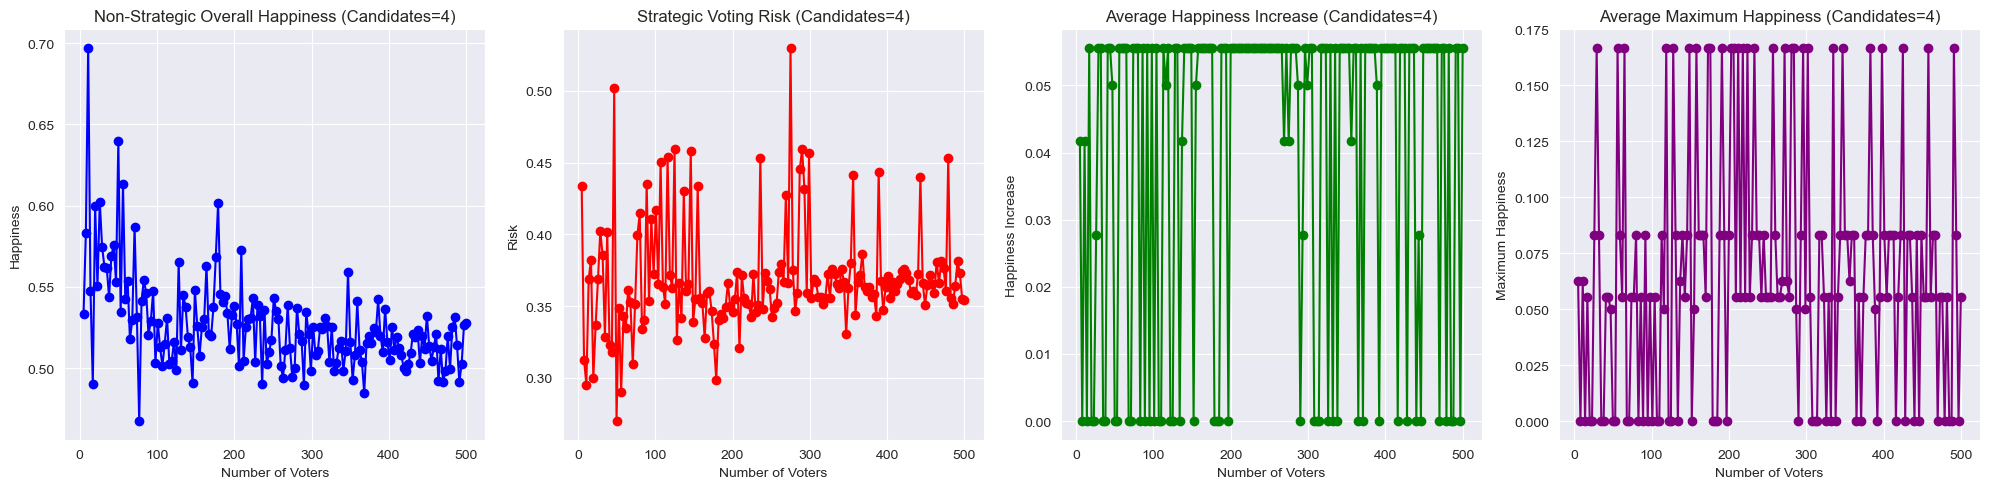

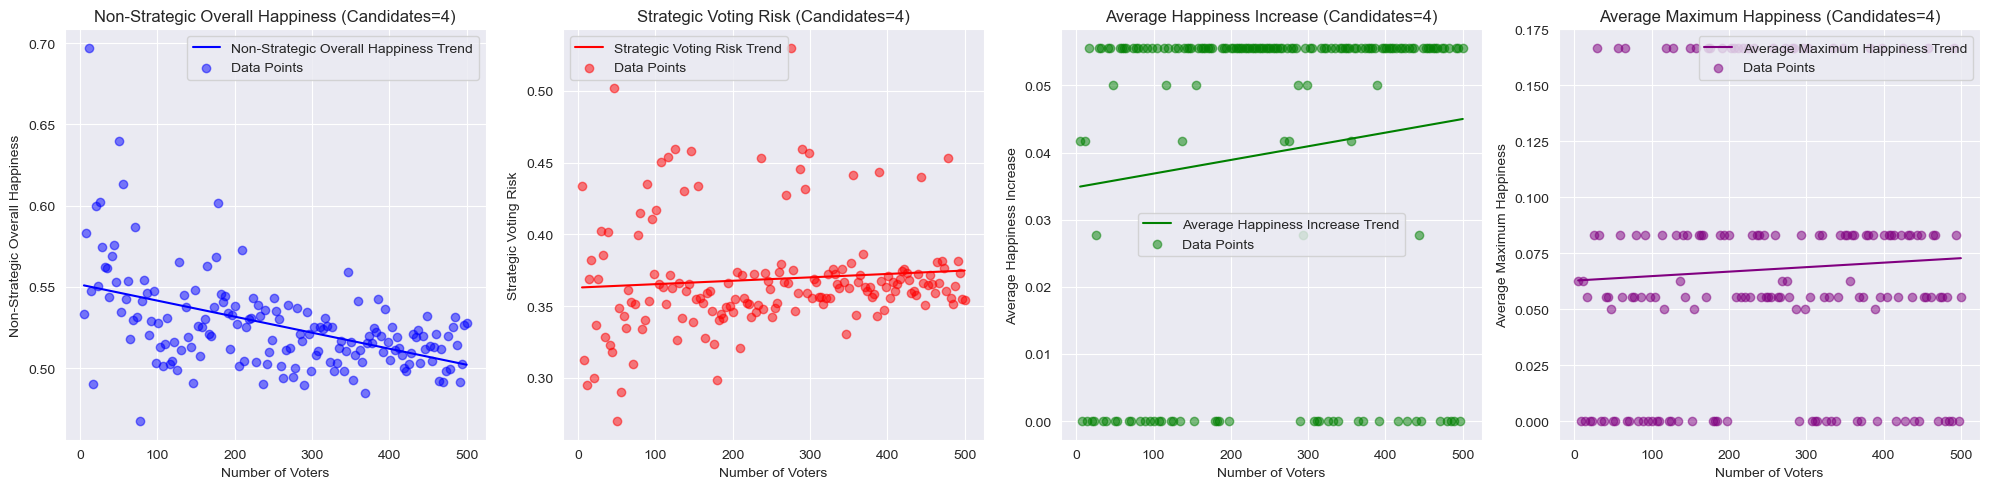

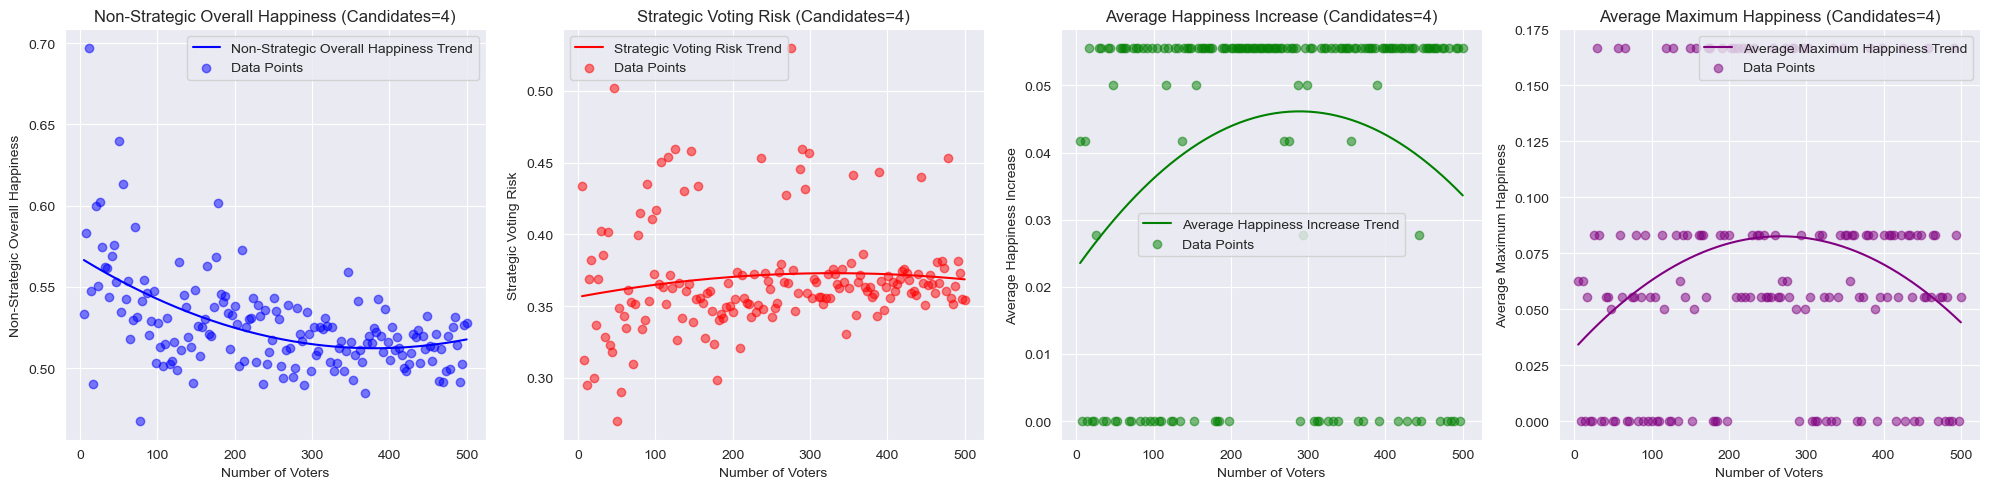

In [22]:
# candidate_numbers = [4]  # Range of candidate numbers to test
# voter_numbers = list(range(5, 501, 3))  # Range of voter numbers to test
# 
# results, voter_numbers = run_experiment(candidate_numbers, voter_numbers, schemes)
# #plot_combined_metrics(results, voter_numbers)
# plot_combined_metrics_with_trends(results, voter_numbers)
# plot_combined_metrics_with_nonlinear_trends(results, voter_numbers)

Running experiment for 1 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 2 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 3 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 4 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 5 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 6 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 7 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 8 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 9 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 10 voters
Number of candidates: 4
Results written to exp_output.json
Running experiment for 11 voters
Number of candidates: 4
Results written to exp_output.js

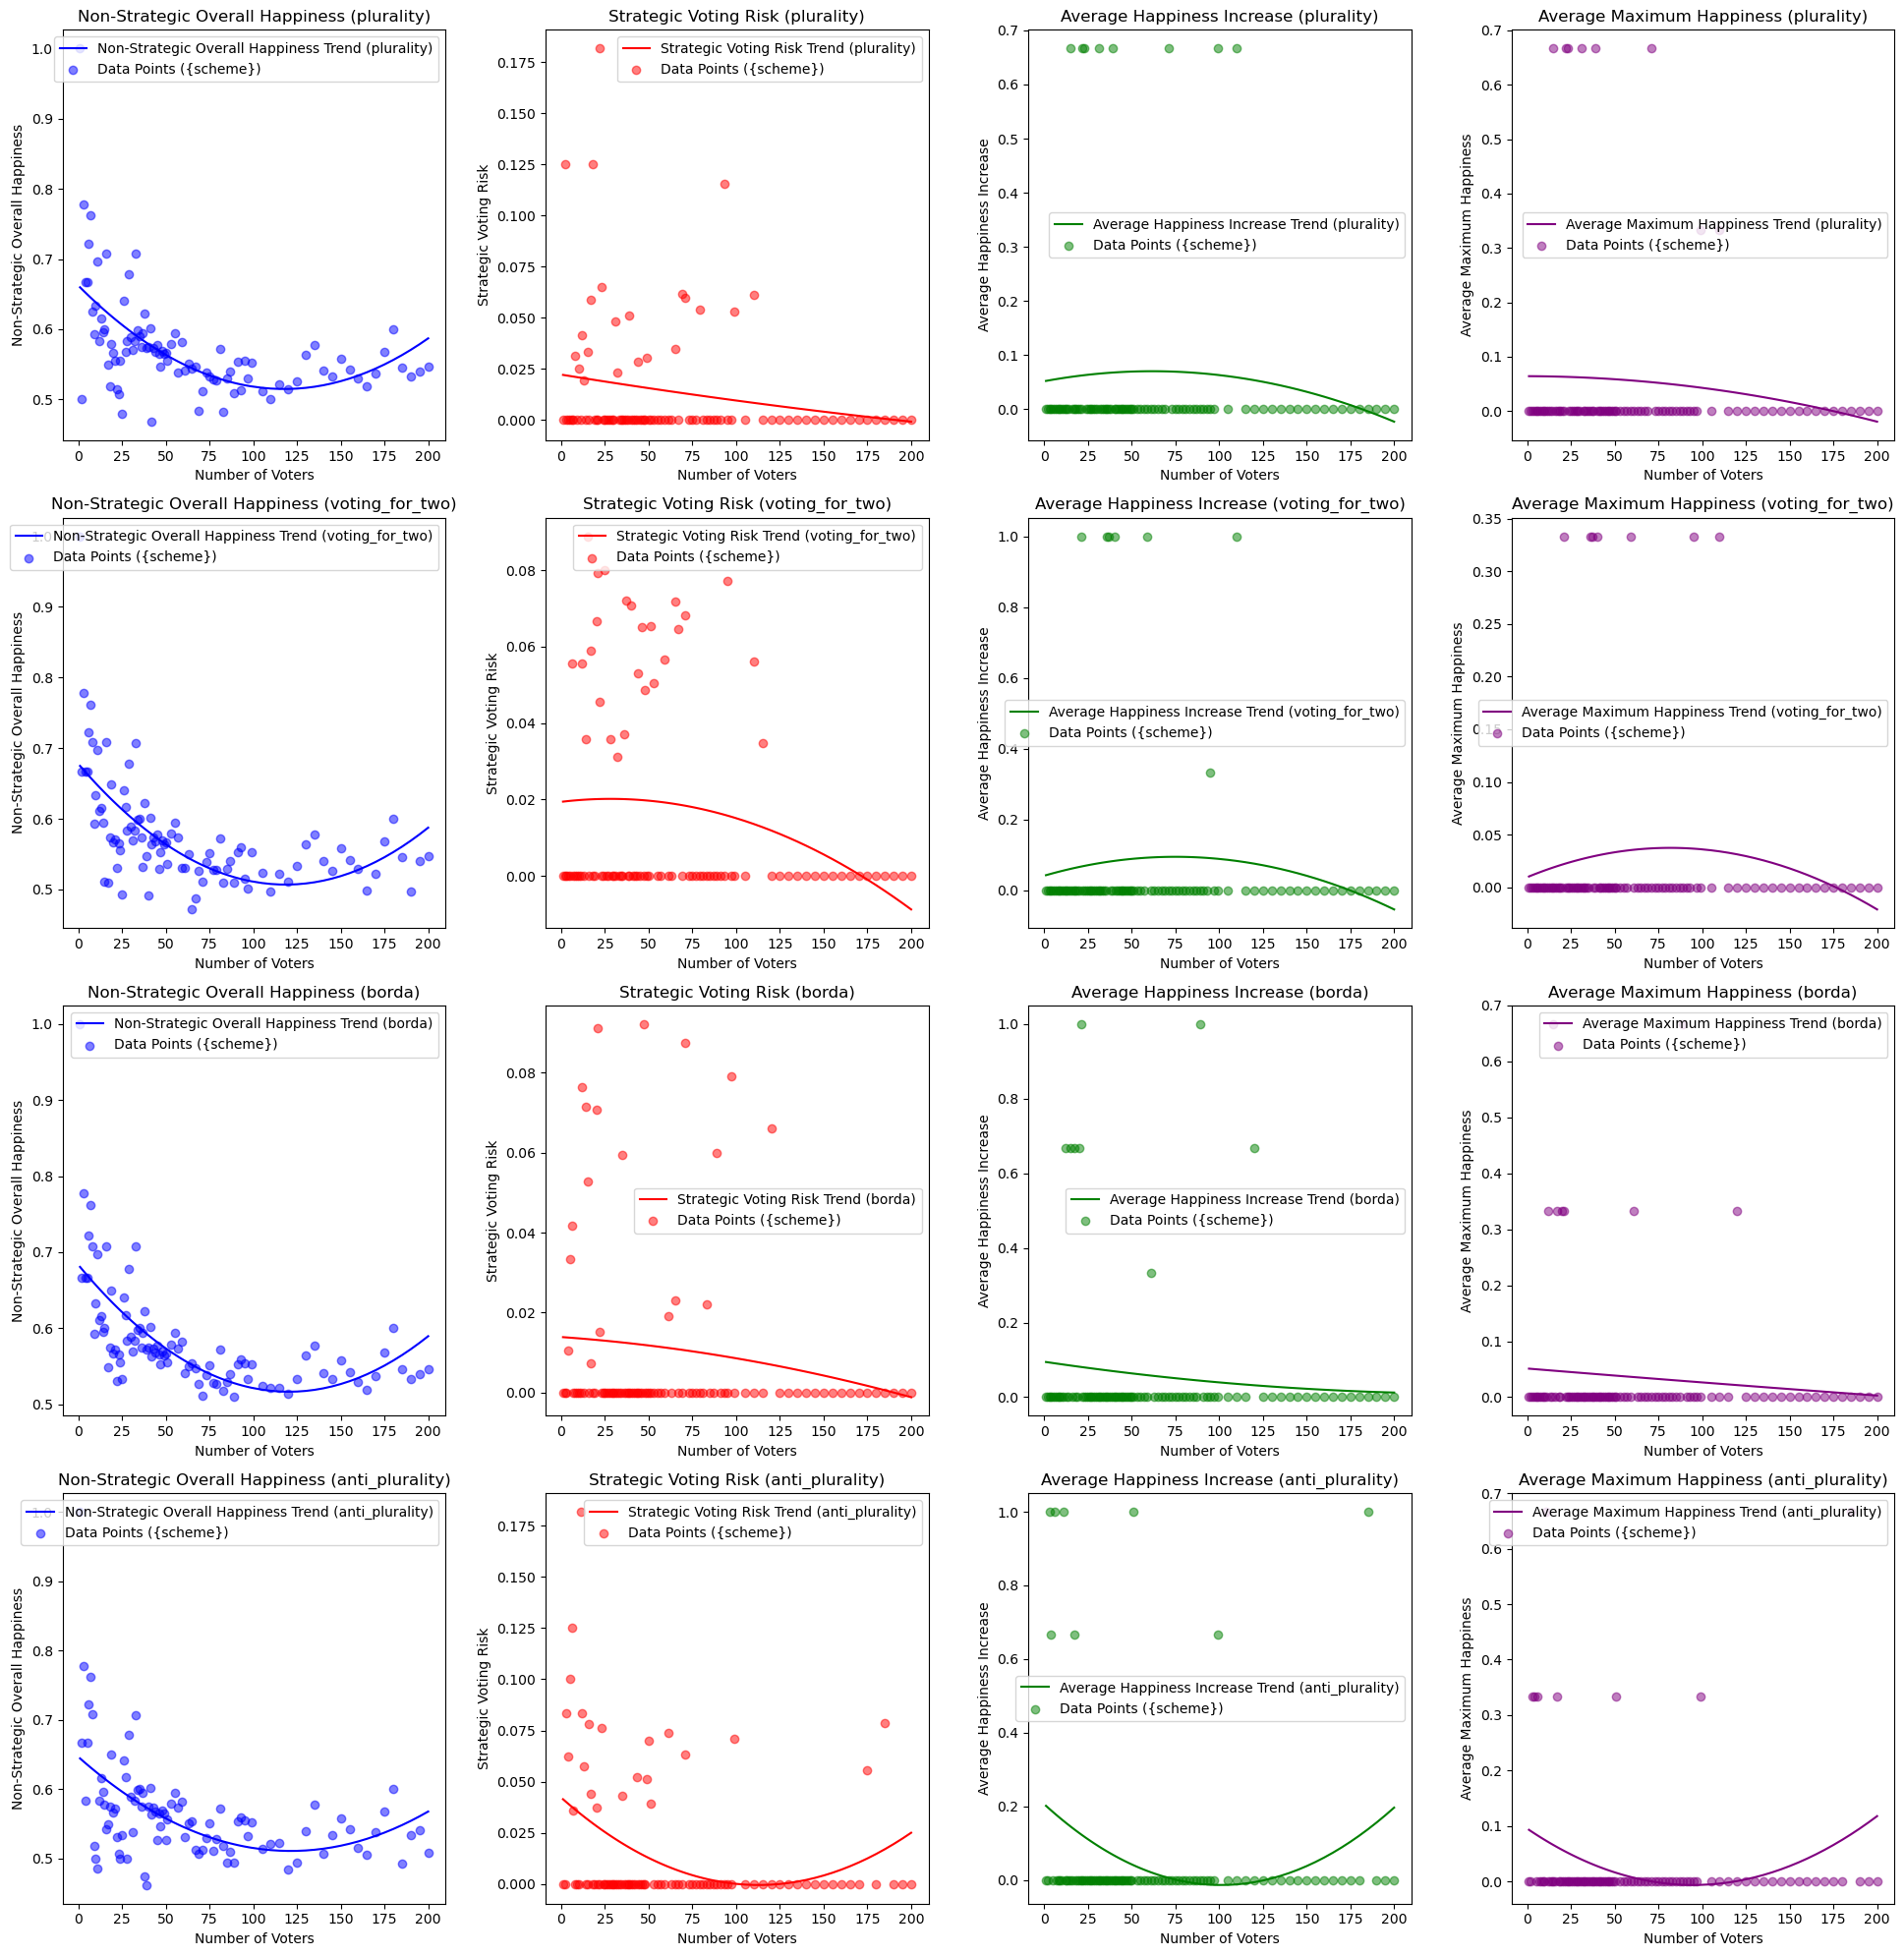

In [21]:

candidate_numbers = [4]  # Range of candidate numbers to test
voter_numbers_part1 = list(range(1, 51))  # 1 increment for the first 50 numbers
voter_numbers_part2 = list(range(51, 101, 2))  # 2 increments for the next 50 numbers
voter_numbers_part3 = list(range(105, 201, 5))  # 5 increments for the rest, starting at 105 to avoid overlap

voter_numbers_combined = voter_numbers_part1 + voter_numbers_part2 + voter_numbers_part3

results, voter_numbers = run_experiment(candidate_numbers, voter_numbers_combined, schemes)
print("Results keys: ", results.keys())
print("Results values: ", results.values())
plot_metrics_for_all_schemes(results, voter_numbers, schemes)
# plot_combined_metrics_with_trends(results, voter_numbers)
# plot_combined_metrics_with_nonlinear_trends(results, voter_numbers)

+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------

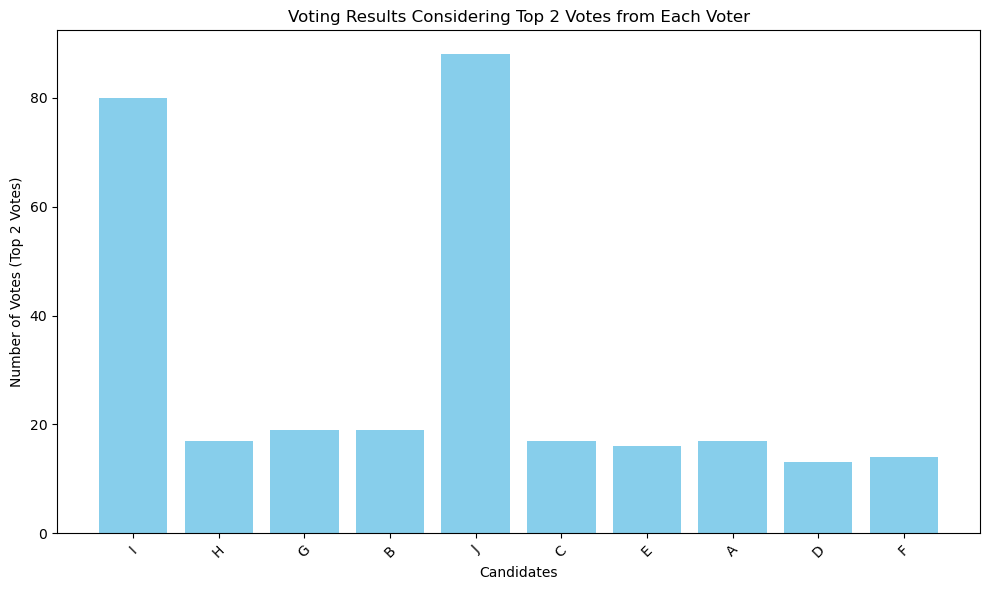

In [53]:
from typing import Counter
from prettytable import PrettyTable


def generate_biased_preferences_csv(num_voters: int, num_candidates: int, filename: str, x: float, y: float) -> None:
    top_candidates_count = max(1, round(num_candidates * x))
    total_top_votes = max(1, round(num_voters * y))

    # Initialize candidate lists
    candidates = [chr(65 + i) for i in range(num_candidates)]
    top_candidates = random.sample(candidates, top_candidates_count)
    other_candidates = [c for c in candidates if c not in top_candidates]

    # Calculate votes per voter for top candidates
    votes_per_voter_for_top = max(1, round(total_top_votes / num_voters))

    # Initialize preferences for each voter
    preferences = [[] for _ in range(num_voters)]

    # Distribute votes for top candidates evenly across voters
    for _ in range(votes_per_voter_for_top):
        for voter in range(num_voters):
            # Ensure each voter has a unique set of top candidates per iteration
            remaining_top_candidates = [c for c in top_candidates if c not in preferences[voter]]
            if remaining_top_candidates:
                preferences[voter].append(random.choice(remaining_top_candidates))

    # Fill remaining preferences with other candidates, ensuring no duplicates
    for voter_preferences in preferences:
        remaining_candidates = [c for c in candidates if c not in voter_preferences]
        voter_preferences.extend(random.sample(remaining_candidates, len(remaining_candidates)))

    # Transpose to align preferences by voter in columns for CSV
    transposed_preferences = list(zip(*preferences))

    # Write to CSV, each voter's preferences in a column
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(transposed_preferences)
    
def print_csv_as_table(filename: str) -> None:
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        table = PrettyTable()
        for row in reader:
            table.add_row(row)
        print(table)
        
def plot_voting_results_top_x_votes(filename: str, x_votes: int):
    """
    Plot voting results, considering only the top x votes from each voter.

    :param filename: The path to the CSV file with voting preferences.
    :param x_votes: The top number of votes to consider from each voter.
    """
    import csv
    from collections import Counter
    import matplotlib.pyplot as plt

    vote_counts = Counter()

    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Assuming each row in the CSV corresponds to a candidate's votes across all voters
        # Convert rows to columns to get each voter's preferences
        voters_preferences = list(zip(*reader))

        # Collect the top x votes from each voter
        for voter in voters_preferences:
            vote_counts.update(voter[:x_votes])

    # Separate the data for plotting
    candidates, counts = zip(*vote_counts.items())

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(candidates, counts, color='skyblue')
    plt.xlabel('Candidates')
    plt.ylabel(f'Number of Votes (Top {x_votes} Votes)')
    plt.title(f'Voting Results Considering Top {x_votes} Votes from Each Voter')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
generate_biased_preferences_csv(150, 10, "exp_preferences.csv", 0.2, 0.7)
print_csv_as_table("exp_preferences.csv")
plot_voting_results_top_x_votes("exp_preferences.csv",2)

